# Author Note

In this work, my aim is to gain a comprehensive understanding of the dataset and uncover valuable insights. To ensure clarity and transparency, I have documented my thought process, steps, and observations throughout the analysis.

Before every visualization, I often ask a question or explain what is this chart used for, and let the chart explain/answer my question or support me make conclusion, and after every chart, I always make a conclusion or explain what is the chart indicating.

By the way, there are few places where the code is less but the explaination is much, so hopefully reader can spent time to read all, **as my objective is all readers can understand what I'm doing.**

# Introducing the Tiki E-commerce Dataset
Crawled directly from the Tiki website, the dataset encompasses a vast range of product details, allowing analysts to explore and uncover insights into the products. With information on thoudsands of products, the dataset covers diverse categories such as electronics, fashion, home appliances, books, and more.

Each entry in the dataset contains a wealth of information, including product names, descriptions, prices, ratings, customer reviews, seller information, and other relevant attributes. This rich variety of data offers the opportunity to delve into various dimensions of e-commerce, such as consumer behavior, pricing strategies, market trends, and product popularity.

In [ ]:
import requests
import json
import pandas as pd
import csv
import os
import math
from time import sleep
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from collections import Counter
import re
from sklearn.cluster import *

pd.set_option('display.float_format', lambda x: '%.5f' % x)
sns.set_style("darkgrid")

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/tiki_data')

Mounted at /content/drive


# Load the Data
Due to the time limited and the size of project, I will just use a small subset of the dataset to speed up processing

In [ ]:
def load_data(folder_path):
    csv_files = glob.glob(folder_path + "/" + "*.csv")
    dfs = []
    for f in csv_files:
        dfs.append(pd.read_csv(f))

    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df.drop_duplicates(subset="id", keep="first", inplace=True)
    combined_df = combined_df.reset_index()
    combined_df.drop('index', axis=1, inplace=True)
    return combined_df

## Load data into DataFrame and take a glance at some first rows

In [ ]:
df = load_data('eda_data')
df.head(3)

,price,day_ago_created,data_version,add_on_title,is_tier_pricing_eligible,configurable_options,badges,id,is_fresh,short_description,...,stock_item,breadcrumbs,name,favourite_count,meta_keywords,master_id,sku,meta_description,warranty_policy,salable_type
0,54650,2303,3300,NaN,False,NaN,"[{'code': 'has_book_preview', 'text': 'Đọc thử...",429450,False,Những Truyện Hay Viết Cho Thiếu Nhi - Vũ Tú Na...,...,"{'max_sale_qty': 1000, 'min_sale_qty': 1, 'pre...","[{'url': '/nha-sach-tiki/c8322', 'name': 'Nhà ...",Những Truyện Hay Viết Cho Thiếu Nhi - Vũ Tú Na...,0,NaN,429450,2526217453364,NaN,NaN,NaN
1,24030,2303,3300,NaN,False,NaN,"[{'code': 'has_book_preview', 'text': 'Đọc thử...",445872,False,Những Gương Mặt Làm Thay Đổi Thế Giới - Harry ...,...,"{'max_sale_qty': 1000, 'min_sale_qty': 1, 'pre...","[{'url': '/nha-sach-tiki/c8322', 'name': 'Nhà ...",Những Gương Mặt Làm Thay Đổi Thế Giới - Harry ...,0,NaN,445872,2527190505583,NaN,NaN,NaN
2,128500,0,3300,NaN,False,NaN,"[{'code': 'new_pdp', 'text': 'v1'}]",394685,False,Nước Xịt Khoáng Evoluderm 150ml – 12206 ...,...,"{'max_sale_qty': 1000, 'min_sale_qty': 1, 'pre...","[{'url': '/lam-dep-suc-khoe/c1520', 'name': 'L...",Nước Xịt Khoáng Evoluderm 150ml – 12206,0,NaN,394685,1332194127669,NaN,NaN,NaN


View contents inside a specific row

In [ ]:
for c in df.columns:
    print(c, ': ', df.iloc[3][c])

price :  290000
day_ago_created :  0
data_version :  3300
add_on_title :  nan
is_tier_pricing_eligible :  False
configurable_options :  nan
badges :  [{'code': 'new_pdp', 'text': 'v1'}]
id :  444670
is_fresh :  False
short_description :  Công suất lớnBàn ủi Electrolux EDI2004 được thiết kế dạng bàn ủi khô hoạt động mạnh mẽ với công suất 1300W giúp ủi thẳng quần áo nhanh chóng, tiết kiệm thời gian. Có 1 bình nước nhỏ, khi ủi có thể...
review_count :  10
promitions :  []
warranty_info :  [{'name': 'Thời gian bảo hành', 'value': '24 Tháng'}, {'name': 'Hình thức bảo hành', 'value': 'Phiếu bảo hành'}, {'name': 'Nơi bảo hành', 'value': 'Bảo hành bởi nhà bán hàng thông qua Tiki'}, {'name': 'Hướng dẫn bảo hành', 'value': 'Xem chi tiết', 'url': 'https://hotro.tiki.vn/s/article/chinh-sach-bao-hanh-tai-tiki-nhu-the-nao'}]
inventory :  {'product_virtual_type': None, 'fulfillment_type': 'seller_delivery'}
review_text :  (10)
quantity_sold :  {'text': 'Đã bán 43', 'value': 43}
list_price :  370000
i

We see that some values are stored inside brackets, see must handle this kind of value first because there may be useful information inside. This works required a lot of patience!

Values `warranty_info` column seems to be useful for us, let's flatten them and save values into new columns

In [ ]:
def flatten_warranty_info(row):
    vls = row['warranty_info']
    try:
        for info in eval(vls):
            column_name = info.get('name')
            column_value = info.get('value')
            if column_name:
                row[column_name] = column_value
    except:
        pass

    return row

df = df.apply(flatten_warranty_info, axis=1)
# Check for the 3rd row to see whether our funciton is working or not
df.iloc[3]

Hình thức bảo hành                                       Phiếu bảo hành
Hướng dẫn bảo hành                                         Xem chi tiết
Nơi bảo hành                   Bảo hành bởi nhà bán hàng thông qua Tiki
Thời gian bảo hành                                             24 Tháng
add_on                                                              NaN
                                            ...                        
stock_item            {'max_sale_qty': 1000, 'min_sale_qty': 1, 'pre...
type                                                             simple
video_url                                                           NaN
warranty_info         [{'name': 'Thời gian bảo hành', 'value': '24 T...
warranty_policy                                                     NaN
Name: 3, Length: 74, dtype: object

For the `inventory` we'll take the value of `fulfillment_type` field and save into new column, then we drop  `inventory` column 'cause we don't need it anymore

In [ ]:
def flatten_inventory(row):
    vls = eval(row['inventory'])
    if pd.notnull(vls):
        row['fulfillment_type'] = vls.get('fulfillment_type')
        return row

df = df.apply(flatten_inventory, axis=1)

Take the value `store_id` inside `current_seller` column

In [ ]:
def flatten_current_seller(row):
    if pd.notnull(row['current_seller']):
        vls = eval(row['current_seller'])
        if pd.notnull(vls):
            row['store_id'] = vls.get('store_id')
            row['seller_name'] = vls.get('name')
            return row

df = df.apply(flatten_current_seller, axis=1)

## Drop unuse columns

Why we have to drop these columns?
- Its values are not relating to our analysis purpose. Such columns like product_link, values contain url mean nothing for our work.
- Values are complex, such columns like `description` need to be cleaned and analyzer have to do some NLP stuffs to make it really useful. That works take a lot of time, for this project which is very time limited, I decide to skip this kind of column.

In [ ]:
cols_to_drop = ['description', 'add_on_title', 'badges', 'promitions', 'configurable_options', 'warranty_info', 'current_seller',
                'asa_cashback_widget', 'breadcrumbs', 'categories', 'installment_info_v2', 'specifications', 'badges_new', 'Nơi bảo hành',
                'Hướng dẫn bảo hành', 'inventory','gift_item_title', 'stock_item', 'return_and_exchange_policy', 'product_links']
# warranty_info column will be dropped because we don't need it anynmore, its values are moved into new columns
df = df.drop(cols_to_drop, axis=1)
for c in df.columns:
    print(c, ':', df.iloc[3][c])

Hình thức bảo hành : Phiếu bảo hành
Thời gian bảo hành : 24 Tháng
add_on : nan
all_time_quantity_sold : 43.0
authors : nan
benefits : [{'icon': 'https://salt.tikicdn.com/ts/upload/2c/48/44/720434869e103b03aaaf1a104d91ad25.png', 'text': 'Hoàn tiền<br><b>111%</b><br>nếu hàng giả'}, {'icon': 'https://salt.tikicdn.com/ts/upload/4b/a1/23/1606089d5423e5cba05e3820ad39708e.png', 'text': 'Thông tin<br>bảo hành', 'extra_text': 'XEM CHI TIẾT', 'extra_header': 'Thông tin bảo hành', 'extra': [{'name': 'Nhà cung cấp', 'value': 'Nguyễn Kim Official'}, {'name': 'Thời gian bảo hành', 'value': '24 Tháng'}, {'name': 'Hình thức bảo hành', 'value': 'Phiếu bảo hành'}, {'name': 'Nơi bảo hành', 'value': 'Bảo hành bởi nhà bán hàng thông qua Tiki'}, {'name': 'Hướng dẫn bảo hành', 'value': 'Xem chi tiết', 'url': 'https://hotro.tiki.vn/s/article/chinh-sach-bao-hanh-tai-tiki-nhu-the-nao'}]}, {'icon': 'https://salt.tikicdn.com/ts/upload/63/75/6a/144ada409519d72e2978ad2c61bc02a7.png', 'text': 'Đổi trả trong<br><b>7 

The data is a bit less messy, let's dive into the exploration step!

## Checking for the nonnull count and types of data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8054 entries, 0 to 8053
Data columns (total 57 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Hình thức bảo hành           801 non-null    object 
 1   Thời gian bảo hành           868 non-null    object 
 2   add_on                       213 non-null    object 
 3   all_time_quantity_sold       4328 non-null   float64
 4   authors                      1775 non-null   object 
 5   benefits                     7925 non-null   object 
 6   best_price_guaranteed        262 non-null    object 
 7   book_cover                   0 non-null      float64
 8   brand                        5510 non-null   object 
 9   configurable_products        2925 non-null   object 
 10  data_version                 7925 non-null   float64
 11  day_ago_created              7925 non-null   float64
 12  deal_specs                   40 non-null     object 
 13  discount          

### Checkpoint 1
I initialize the Checkpoint incase we want our DataFrame get back to its previous state

At this point our dataset has 8054 rows, 61 columns

In [ ]:
# Save the checkpoint for reusing purpose
processed1_df = df.copy()

# Overview the Data



## Dealing with null values

First thing to do is looking at the data information, which will provide us the number of rows, columns, information of any specific column such as name, non-null count, datatype see data types and null percentage.

Then I show the percentage of null values per column, we should have better understanding about number of null values compared to total entries

In [ ]:
processed1_df.info(), (processed1_df.isnull().sum() / len(processed1_df)) * 100

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8054 entries, 0 to 8053
Data columns (total 57 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Hình thức bảo hành           801 non-null    object 
 1   Thời gian bảo hành           868 non-null    object 
 2   add_on                       213 non-null    object 
 3   all_time_quantity_sold       4328 non-null   float64
 4   authors                      1775 non-null   object 
 5   benefits                     7925 non-null   object 
 6   best_price_guaranteed        262 non-null    object 
 7   book_cover                   0 non-null      float64
 8   brand                        5510 non-null   object 
 9   configurable_products        2925 non-null   object 
 10  data_version                 7925 non-null   float64
 11  day_ago_created              7925 non-null   float64
 12  deal_specs                   40 non-null     object 
 13  discount          

(None,
 Hình thức bảo hành             90.05463
 Thời gian bảo hành             89.22275
 add_on                         97.35535
 all_time_quantity_sold         46.26273
 authors                        77.96126
 benefits                        1.60169
 best_price_guaranteed          96.74696
 book_cover                    100.00000
 brand                          31.58679
 configurable_products          63.68264
 data_version                    1.60169
 day_ago_created                 1.60169
 deal_specs                     99.50335
 discount                        1.60169
 discount_rate                   1.60169
 favourite_count                 1.60169
 has_buynow                      1.60169
 has_ebook                       1.60169
 id                              1.60169
 inventory_status                1.60169
 inventory_type                  1.60169
 is_acoholic_drink               1.60169
 is_baby_milk                    1.60169
 is_flower                       1.60169
 is_fresh

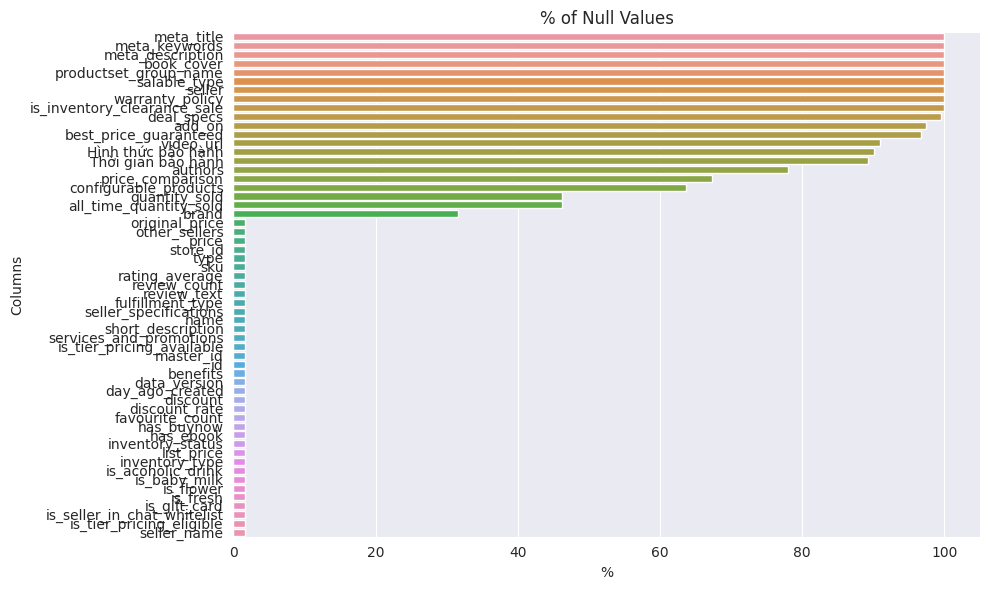

In [ ]:
def plot_null(df):
    # Calculate the percentage of null values for each column
    percentage_null = (df.isnull().sum() / len(df)) * 100
    percentage_null = percentage_null.sort_values(ascending=False)
    percentage_null = percentage_null[percentage_null > 0]

    # Create a bar chart using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=percentage_null, y=percentage_null.index)

    # Set chart information
    plt.title("% of Null Values")
    plt.xlabel("%")
    plt.ylabel("Columns")
    plt.tight_layout()
    plt.show()

plot_null(processed1_df)

With the columns that have more than 95% null values should be dropped

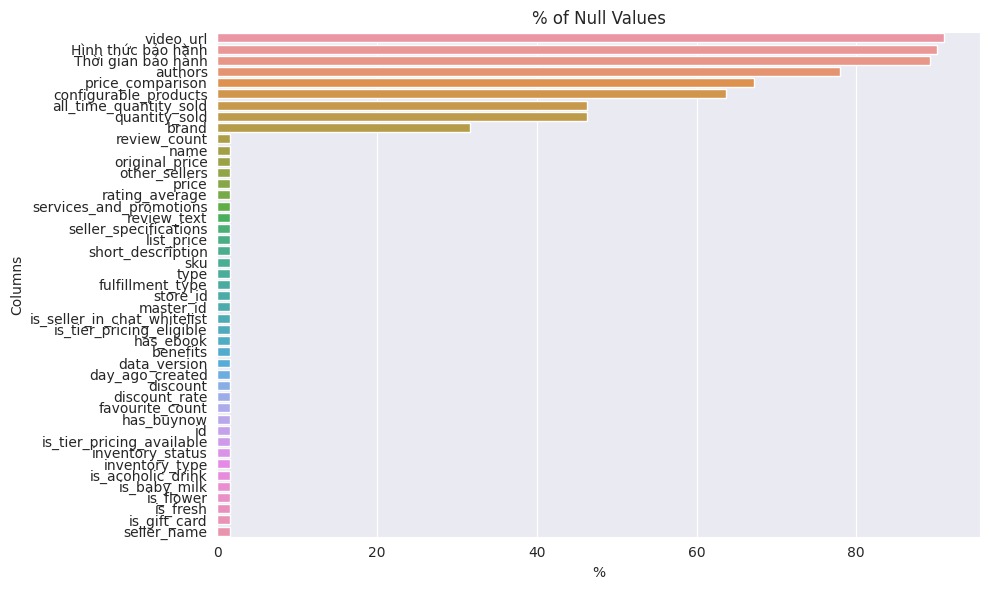

In [ ]:
percent_threshold = 95
percentage_null = (processed1_df.isnull().sum() / len(df)) * 100
percentage_null = percentage_null[percentage_null > percent_threshold]
processed1_df = processed1_df.drop(percentage_null.index, axis=1)
# Plot the % null again to see the differences
plot_null(processed1_df)

The chart looks nicer! But I want it even more, by filtering out columns that have less than 5% null values, and removing those null value rows

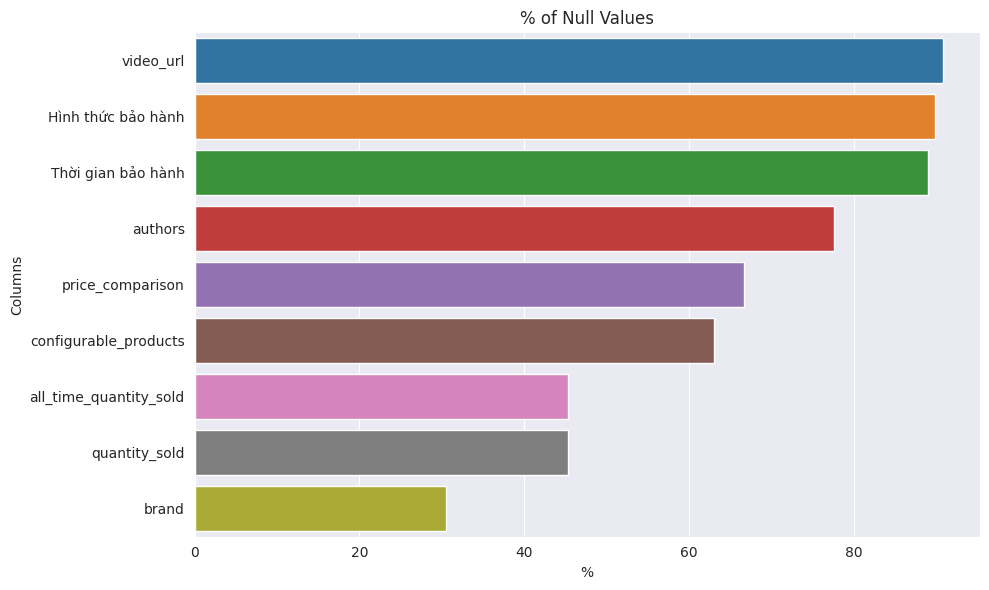

In [ ]:
percent_threshold = 5
percentage_null = (processed1_df.isnull().sum() / len(df)) * 100

# Get columns that have % null value less than 5
cols_have_low_percentage_null = percentage_null[percentage_null < percent_threshold]
cols_have_low_percentage_null = cols_have_low_percentage_null[cols_have_low_percentage_null > 0]

# Drop
processed1_df = processed1_df.dropna(subset=cols_have_low_percentage_null.index).reset_index(drop=True)

# Plot the % null again to see the differences
plot_null(processed1_df)

For the column such as `video_url`, `Hình thức bảo hành`, `Nơi bảo hành`, ... I have the idea that is we just transform these columns into boolean columns, meaning that if the value exists, we map it into 1 indicate that this value is not null, for the null value we'll map it into 0

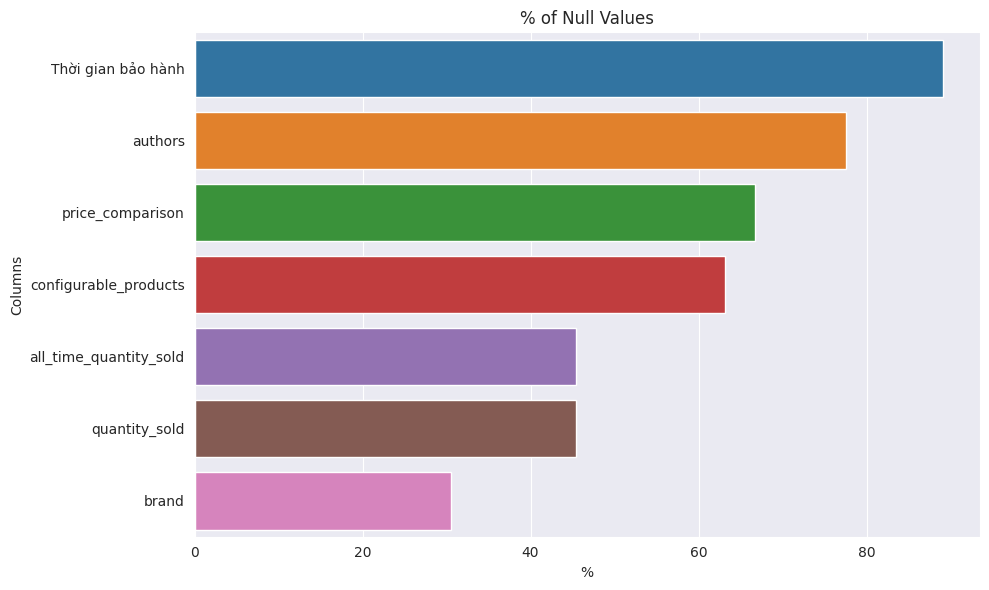

In [ ]:
def to_bool_col(df, col_list):
    for c in col_list:
        df[c] = df[c].map(lambda x: 1 if pd.notnull(x) else 0)
    return df

to_bool_cols = ['video_url', 'Hình thức bảo hành']
processed1_df = to_bool_col(processed1_df, to_bool_cols)

processed1_df = processed1_df.rename(columns={'video_url': 'has_video_url', 'Hình thức bảo hành': 'has_warranty_method'})

plot_null(processed1_df)

Now there are just few columns that have null value left

Let's see what is inside decide the method to handle with these columns.

In [ ]:
# This function will help us print out some non-null values of given column
def print_random_values(df, col, n=5):
    filtered_df = processed1_df[processed1_df[col].notnull()]
    for i in filtered_df[col].sample(n):
        print(i)

---

In [ ]:
print_random_values(processed1_df, 'brand')

{'id': 19813, 'name': 'Tefal', 'slug': 'tefal'}
{'id': 19813, 'name': 'Tefal', 'slug': 'tefal'}
{'id': 111461, 'name': 'OEM', 'slug': 'oem'}
{'id': 165403, 'name': 'Rapido', 'slug': 'rapido'}
{'id': 111461, 'name': 'OEM', 'slug': 'oem'}


For `brand` column I will take only the value `slug`, and set 'none' for null values

In [ ]:
processed1_df['brand'] = processed1_df['brand'].apply(lambda x: eval(x).get('slug') if pd.notnull(x) else 'none')

---

In [ ]:
print_random_values(processed1_df, 'quantity_sold')

{'text': 'Đã bán 186', 'value': 186}
{'text': 'Đã bán 2043', 'value': 2043}
{'text': 'Đã bán 1', 'value': 1}
{'text': 'Đã bán 285', 'value': 285}
{'text': 'Đã bán 1', 'value': 1}


For the `quantity_sold` column, its values is a dictionary, we'll keep the second element

In [ ]:
processed1_df['quantity_sold'] = processed1_df['quantity_sold'].apply(lambda x: eval(x).get('value') if pd.notnull(x) else 0)

---

In [ ]:
for i in range(10):
    print(processed1_df['all_time_quantity_sold'].iloc[i], processed1_df['quantity_sold'].iloc[i])

nan 0
1.0 1
62.0 62
43.0 43
48.0 48
2.0 2
6.0 6
nan 0
nan 0
nan 0


`all_time_quantity_sold` column is quite similar to `quantity_sold`, so just drop it out

In [ ]:
processed1_df = processed1_df.drop('all_time_quantity_sold', axis=1).reset_index(drop=True)

---

In [ ]:
print_random_values(processed1_df, 'configurable_products')

[{'child_id': 242461384, 'id': 242461389, 'images': [{'large_url': 'https://salt.tikicdn.com/cache/w1200/ts/product/16/cc/79/91abb824cf894e0b4cb62feae8a77de7.jpg', 'medium_url': 'https://salt.tikicdn.com/cache/550x550/ts/product/16/cc/79/91abb824cf894e0b4cb62feae8a77de7.jpg', 'small_url': 'https://salt.tikicdn.com/cache/200x280/ts/product/16/cc/79/91abb824cf894e0b4cb62feae8a77de7.jpg'}, {'large_url': 'https://salt.tikicdn.com/cache/w1200/ts/product/1a/12/15/b3dc41ae543297321287d9241c145296.jpg', 'medium_url': 'https://salt.tikicdn.com/cache/550x550/ts/product/1a/12/15/b3dc41ae543297321287d9241c145296.jpg', 'small_url': 'https://salt.tikicdn.com/cache/200x280/ts/product/1a/12/15/b3dc41ae543297321287d9241c145296.jpg'}, {'large_url': 'https://salt.tikicdn.com/cache/w1200/ts/product/1a/44/4a/010efe657de98ac5a23374eef2db16df.jpg', 'medium_url': 'https://salt.tikicdn.com/cache/550x550/ts/product/1a/44/4a/010efe657de98ac5a23374eef2db16df.jpg', 'small_url': 'https://salt.tikicdn.com/cache/200x

The values are not really useful, so just drop this column too

In [ ]:
processed1_df = processed1_df.drop('configurable_products', axis=1).reset_index(drop=True)

---

In [ ]:
print_random_values(processed1_df, 'price_comparison')

{'sub_title': 'Giá từ 214.000 ₫', 'title': '6 nhà bán khác'}
{'sub_title': 'Giá từ 70.000 ₫', 'title': '4 nhà bán khác'}
{'sub_title': 'Giá từ 60.200 ₫', 'title': '6 nhà bán khác'}
{'sub_title': 'Giá từ 82.800 ₫', 'title': '8 nhà bán khác'}
{'sub_title': 'Giá từ 108.000 ₫', 'title': '1 nhà bán khác'}


`price_comparison` column is an useful column I think

We will take the number value inside the 'sub_title', and for the number value in 'title', we'll move it into a new column named `num_other_seller`

In [ ]:
processed1_df['num_other_seller'] = processed1_df['price_comparison'].apply(
    lambda x: int(re.findall(r'\d+', eval(x).get('title'))[0]) if pd.notnull(x) else 0
)

def extract_price_comparison(row):
    if not pd.notnull(row):
        return 0.0

    pattern = r'^Giá từ\s*|\s*₫$'
    number = re.sub(pattern, '', eval(row).get('sub_title'))
    number = re.sub(r'\.', '', number)
    return float(number)

processed1_df['price_comparison'] = processed1_df['price_comparison'].apply(extract_price_comparison)

---

In [ ]:
print_random_values(processed1_df, 'authors')

[{'id': 525495, 'name': ' Bác sĩ Nguyễn Lan Hải', 'slug': 'bac-si-nguyen-lan-hai'}]
[{'id': 32489, 'name': 'Phúc Lai', 'slug': 'phuc-lai'}]
[{'id': 74906, 'name': 'Bác sĩ Trần Thị Huyên Thảo', 'slug': 'bac-si-tran-thi-huyen-thao'}]
[{'id': 20240, 'name': 'BS. Nguyễn Thị Ngọc Hương', 'slug': 'nguyen-thi-ngoc-huong'}, {'id': 20241, 'name': 'Lê Kim Huệ', 'slug': 'le-kim-hue'}, {'id': 20242, 'name': 'Trương Thị Nhàn', 'slug': 'truong-thi-nhan'}]
[{'id': 663513, 'name': 'Chu Vĩnh Tân', 'slug': 'chu-vinh-tan'}]


This column seems to only appear for the book products, so just drop it

In [ ]:
processed1_df = processed1_df.drop('authors', axis=1).reset_index(drop=True)

---

In [ ]:
processed1_df['Thời gian bảo hành'].unique()

array([nan, '24 Tháng', '2 Năm', '12 Tháng', '', '5 Ngày', '3 Ngày',
       '7 Ngày', '1 Tháng', '15 Ngày', '1 Năm', '5 Năm', '3 Tháng',
       '36 Tháng', '30 Ngày', '6 Tháng', 'Bảo hành trọn đời', '0',
       '48h đổi trả + hỗ trợ sửa lỗi', '[]', '60 Tháng', '12 Ngày',
       '2 Tháng', '25 Năm', '3 Năm', '10 Năm', '12 tháng',
       'Không bảo hành', 'Sản phẩm không hỗ trợ bảo hành', '6 Ngày',
       'Không', '60 tháng', '24 Ngày', '15 Năm', '05 năm'], dtype=object)

The values are time related values, so we'll convert it into number of days

In [ ]:
def convert_to_days(value):
    if pd.isnull(value):
        return 0
    elif 'Tháng' in value:
        months = int(value.split()[0])
        return months * 30
    elif 'Năm' in value:
        years = int(value.split()[0])
        return years * 365
    elif 'Ngày' in value:
        days = int(value.split()[0])
        return days
    elif 'trọn đời' in value:
        return 999999999
    else:
        return 0

processed1_df['warranty_days'] = processed1_df['Thời gian bảo hành'].apply(convert_to_days)
processed1_df = processed1_df.drop('Thời gian bảo hành', axis=1).reset_index(drop=True)

We're done with the missing values, so let's check again to make sure we are right

In [ ]:
print('Number of missing values:', sum(processed1_df.isnull().any()))

Number of missing values: 0


---

One last thing to do is remove all columns that have just one unique value, that kind of columns don't really helpful, just make our dataset messy

In [ ]:
# Get the columns with just one unique value
columns_to_drop = []
for column in processed1_df.columns:
    if processed1_df[column].nunique() == 1:
        columns_to_drop.append(column)

# Drop the columns
processed1_df = processed1_df.drop(columns_to_drop, axis=1)

### Checkpoint 2

In [ ]:
# Save checkpoint
processed2_df = processed1_df.copy()

In [ ]:
processed2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7925 entries, 0 to 7924
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   has_warranty_method  7925 non-null   int64  
 1   benefits             7925 non-null   object 
 2   brand                7925 non-null   object 
 3   day_ago_created      7925 non-null   float64
 4   discount             7925 non-null   float64
 5   discount_rate        7925 non-null   float64
 6   id                   7925 non-null   float64
 7   inventory_type       7925 non-null   object 
 8   list_price           7925 non-null   float64
 9   master_id            7925 non-null   float64
 10  name                 7925 non-null   object 
 11  original_price       7925 non-null   float64
 12  other_sellers        7925 non-null   object 
 13  price                7925 non-null   float64
 14  price_comparison     7925 non-null   float64
 15  quantity_sold        7925 non-null   i

In [ ]:
processed2_df['original_price'] = processed2_df['original_price'].astype(int)

At this point we have 27 columns left, and all the values are non-null. Great!

Now we are able to visualize things to get familiar with its pattern, trending,... But there is one more step that we should do before visualizing, that is **removing outliers**.

## Removing outliers


Why we should remove outliers before visualizing?
Let's imagine we have an array represent salary each month of people in a city. Most of the values are around 10-30M VND/month, except one person has salary 200M/month.

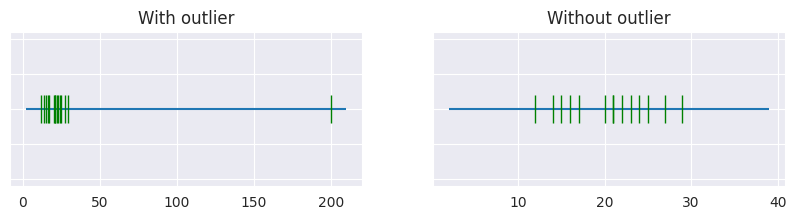

In [ ]:
salaries = [15, 20, 12, 22, 25, 17, 29, 23, 16, 21, 27, 21, 24, 14, 200]
salaries_removed_outlier = salaries[:-1]
y = np.ones(np.shape(salaries))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2))

# Set data with outlier(s)
ax1.hlines(1, min(salaries)-10, max(salaries)+10)   # Draw a horizontal line
ax1.plot(salaries, y,'|',ms=20, color='green')

# Set data without outlier(s)
ax2.hlines(1, min(salaries_removed_outlier)-10, max(salaries_removed_outlier)+10)   # Draw a horizontal line
ax2.plot(salaries_removed_outlier, y[:-1],'|',ms=20, color='green')

# Plot
ax1.set_title('With outlier')
ax1.set_yticklabels([])
ax2.set_title('Without outlier')
ax2.set_yticklabels([])
plt.show()

The right one looks nicer because data is it is not kind of zoomed out to see all values like the left one. That is one of the reasons that we should remove outliers before visualizing

Outlier removing is a crucial step because:
- Outliers can potentially distort our analysis, leading to skewed results and misleading interpretations.
- Outliers can significantly affect statistical measures such as the mean and standard deviation. Removing outliers helps ensure that these measures accurately represent the majority of the data.
- Outliers can distort the shape and interpretation of the data distribution. Removing outliers helps reveal the underlying distribution and allows for more accurate analysis.
- By removing outliers, we can enhance the overall data quality, ensuring that our analysis is based on accurate and reliable information.



Our strategy is to detect outliers is  using IQR, by removing all values that smaller than Q1-1.5*IQR and all values bigger than Q3+1.5IQR.

Read more at https://www.analyticsvidhya.com/blog/2022/09/dealing-with-outliers-using-the-iqr-method/

In [ ]:
def detect_outliers(df, features):
    outlier_indices = []

    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)

    return multiple_outliers

# Define numerical columns that I want to detect outliers
numerical_cols = ['day_ago_created', 'discount', 'discount_rate', 'list_price',
                  'original_price', 'price', 'price_comparison', 'quantity_sold',
                  'review_count', 'num_other_seller', 'warranty_days']

print('outliers detected:', len(processed2_df.loc[detect_outliers(processed2_df, numerical_cols)]))
processed2_df = processed2_df.drop(detect_outliers(processed2_df, numerical_cols), axis=0).reset_index(drop=True)

outliers detected: 1541


## Exploring category columns

To know the balance/imbalance of the dataset, We will visualize the quantity among values of category columns to see the differences

has_warranty_method


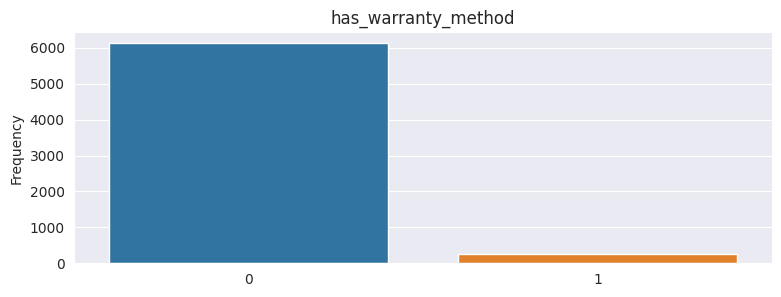

has_warranty_method: 
0    6126
1     258
Name: has_warranty_method, dtype: int64
inventory_type


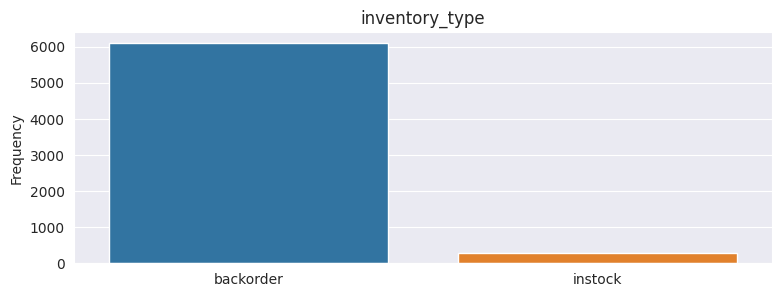

inventory_type: 
backorder    6097
instock       287
Name: inventory_type, dtype: int64
type


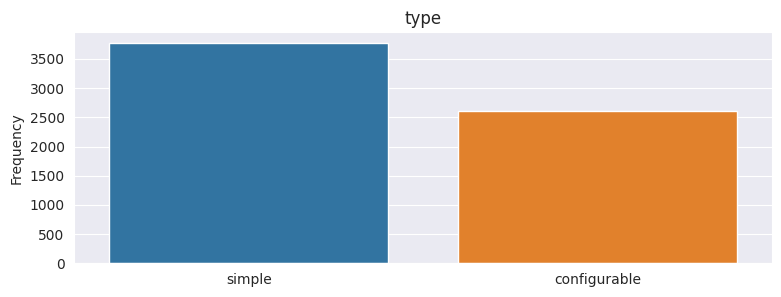

type: 
simple          3768
configurable    2616
Name: type, dtype: int64
has_video_url


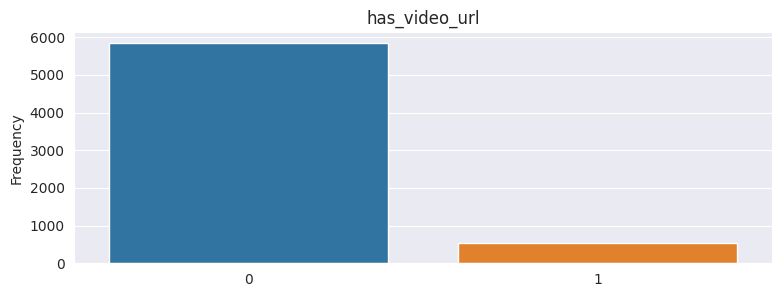

has_video_url: 
0    5839
1     545
Name: has_video_url, dtype: int64
fulfillment_type


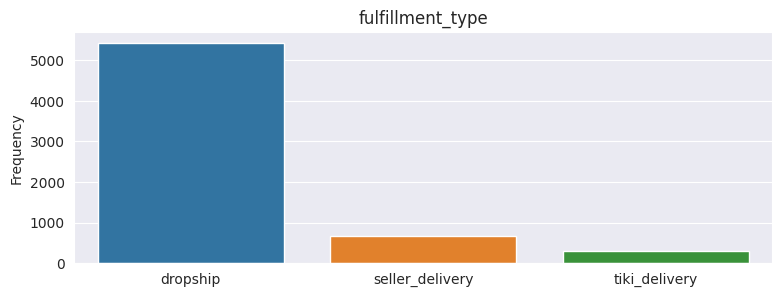

fulfillment_type: 
dropship           5421
seller_delivery     675
tiki_delivery       288
Name: fulfillment_type, dtype: int64


In [ ]:
def barplot_cat_cols(df, n=5):
    for c in df.columns:
        c = str(c)
        if len(df[c].unique()) < n:
            print(c)
            count = df[c].value_counts()

            # visualize
            plt.figure(figsize = (9,3))
            sns.barplot(x=count.index, y=count)
            plt.ylabel("Frequency")
            plt.title(c)
            plt.show()
            print("{}: \n{}".format(c, count))


barplot_cat_cols(processed2_df, 10)

Those chart above indicate that our data is extremely imbalance, we have to careful when using the data for training model.

## Explore the Rating
Ratings are often considered a crucial performance indicator, reflecting customers' satisfaction and perception. By examining this specific variable, you gain an initial understanding of the overall quality or satisfaction level.

Ratings can offer insights into customer preferences and behavior. Exploring the distribution of ratings can provide information about the customers' general sentiment.

### Overall rating per product
We started by exploring the `rating_average` column, which indicated the average rating of the products.



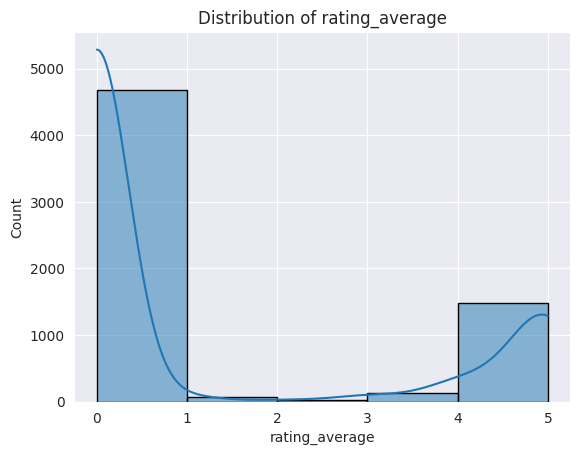

In [ ]:
def plot_hist(df, field, title, bins=10, kde=True):
    sns.histplot(df[field], bins=bins, edgecolor='k', kde=kde)
    plt.xlabel(field)
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

plot_hist(processed2_df, 'rating_average', 'Distribution of rating_average', bins=5)

Surprisingly, a significant proportion of products, most of products had a rating of 0. Just a small portion of products had a rating of 5. Products with ratings from 1 to 4 were relatively scarce.

This distribution said that most of customers are disasitification with the products, a smaller portion of customer are very sastify.

### Explore the rating_average distribution by seller_id
After examining the overall distribution of ratings, I decided to explore how the ratings varied across different sellers. Grouping the data by the `seller_id` column, with the aim to gain insights into the rating patterns specific to each seller.

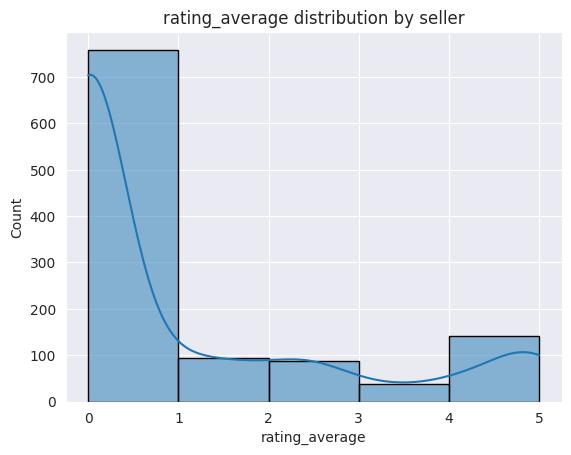

In [ ]:
avg_rating_per_seller = processed2_df.groupby('store_id')['rating_average'].mean().reset_index()
sorted_avg_rating_per_seller = avg_rating_per_seller.sort_values('rating_average', ascending=False)
plot_hist(avg_rating_per_seller, 'rating_average', 'rating_average distribution by seller', bins=5)

Observed that around most sellers had a rating of 0, indicating that a significant portion of sellers received no ratings from customers.

Furthermore, we found that approximately 100 sellers had ratings of 1,  and decreasing gradually to 4. There is a bit increasing in number ratings of 5.

By examining the rating distribution per `store_id`, we gained valuable insights into how different sellers were rated by customers. This information highlighted the diversity in customer satisfaction levels and the varying experiences customers had with different sellers.

### Explore the realtionship between rating_average and review_count
As an online shopping addicted guy, I'm always take a look at the review section before deciding to buy anything, I will just buy the product which have more positive review than negative review. So I think `review_count` will have certain affect to the `rating_average`.

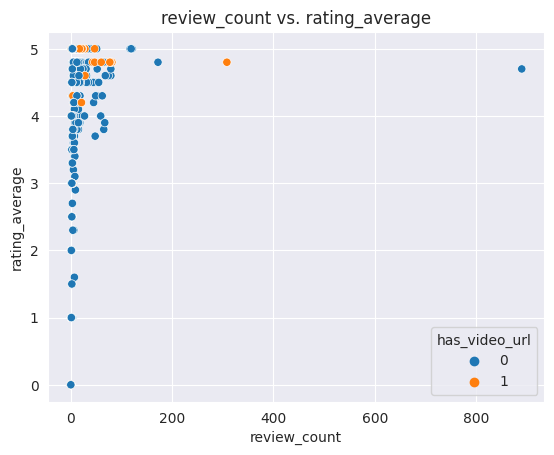

In [ ]:
def plot_scatter(df, f1, f2, hue=None):
    sns.scatterplot(x=df[f1], y=df[f2], data=df, hue=hue)
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title(f'{f1} vs. {f2}')
    plt.show()

plot_scatter(processed2_df, 'review_count', 'rating_average', hue='has_video_url')

There is a trend - a positive relationship between the average rating and the review count. We can easily see that the `review_count` increase, the `rating_average` tends to be higher and vice versa.

Moreover, I have added `has_video_url` factor to see the rating average of products that attached videos. Surprisingly this kind of products get very high ratings. This is a very helpful information.

### Top high-rated seller

Knowing which seller are high appreciate by customers is very important, as Tiki can start some strategies that support, encourage increase their sales, create a win-win relationship

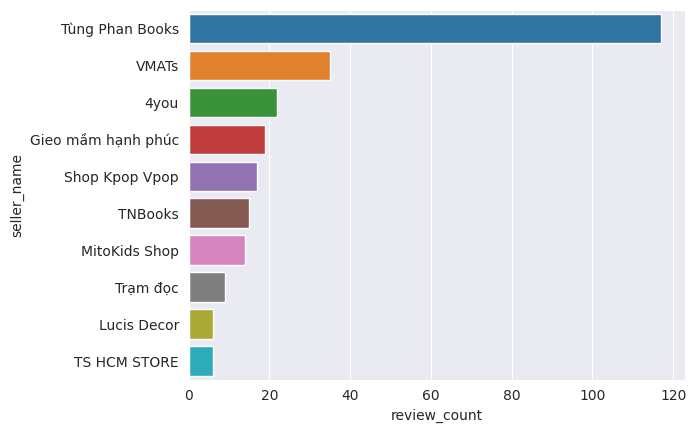

,rating_average,review_count
seller_name,,
Tùng Phan Books,5.00000,117.00000
VMATs,5.00000,35.00000
4you,5.00000,22.00000
Gieo mầm hạnh phúc,5.00000,19.00000
Shop Kpop Vpop,5.00000,17.00000
TNBooks,5.00000,15.00000
MitoKids Shop,5.00000,14.00000
Trạm đọc,5.00000,9.00000
Lucis Decor,5.00000,6.00000


In [ ]:
seller_ratings = processed2_df.groupby('seller_name').agg({'rating_average': 'mean', 'review_count': 'sum'})
seller_ratings = seller_ratings.sort_values(by=['rating_average', 'review_count'], ascending=[False, False])

top = 10
sns.barplot(y=seller_ratings.index[:top], x='review_count', data=seller_ratings.head(top))
plt.show()
seller_ratings.head(top)

These are sellers with the highest average rating and the most number of ratings. These seller stands out as having a consistently high rating and a significant number of satisfied customers.

Tiki can consider to
- Highlight the top-rated sellers on your platform to increase their visibility and attract more customers. Promote their products or services through banners, featured listings, or dedicated sections on your website to showcase their excellence and build trust among your user base.
- Offer incentives to the top-rated sellers to encourage their continued performance and loyalty. This can include benefits such as discounted fees, priority customer support, or additional marketing opportunities. Recognizing and rewarding their efforts can motivate them to maintain their high standards and drive more sales.
- Implement mechanisms to monitor and verify ratings and reviews to ensure their authenticity and fairness. This can help maintain the integrity of your platform and prevent fraudulent practices. Regularly review feedback from buyers and take appropriate action if any issues or concerns arise.

## Relationship between rating_average and branded products

Usually people prefer the branded product rather than nonbranded product, so if we just take all branded products and plot the rating distribution of these products, I think the result will be better

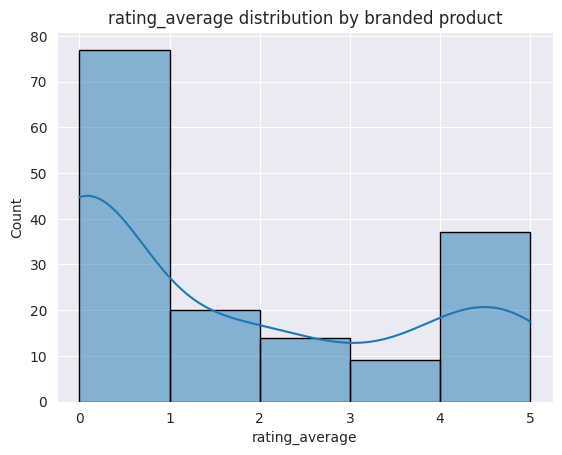

In [ ]:
temp_df = processed2_df.copy()
temp_df['branded'] = processed2_df['brand'].apply(lambda x: 0 if x == 'none' else 1)

avg_rating_per_seller = temp_df.groupby('brand')['rating_average'].mean().reset_index()
sorted_avg_rating_per_seller = avg_rating_per_seller.sort_values('rating_average', ascending=False)
plot_hist(avg_rating_per_seller, 'rating_average', 'rating_average distribution by branded product', bins=5)

As expected, **branded products will get higher ratings on overall if compared to non-branded product**, reason for this probably people usually trust more in branded product.

## Price and Warranty Days

I wonder how `warranty_days` afftect `price`

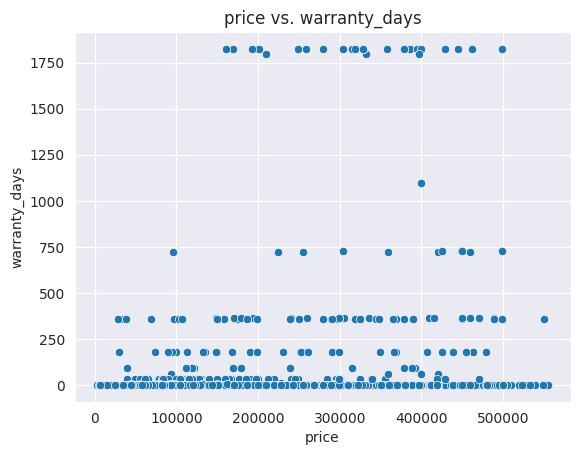

In [ ]:
# Filter out products have warranty_days > 0
temp_df = processed2_df.copy()
temp_df = processed2_df[processed2_df['warranty_days'] > 0]
temp_df = processed2_df[processed2_df['warranty_days'] < 3000]

plot_scatter(temp_df, 'price', 'warranty_days')

There is just no trending in this chart, many products have high price but still not get any warranty. This is not what I was expected, maybe it due to the data is not really reliable, or not big enough for deeper exploration

## Correlation between Number other seller and Discount rate

If  many sellers sell the same product, it's quite competitive, so I have the question: Do the more number of other seller, the higher the discount rate?

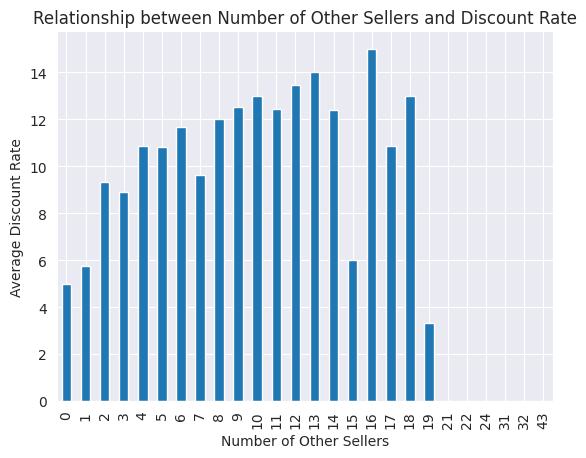

In [ ]:
grouped_data = processed2_df.groupby('num_other_seller')['discount_rate'].mean()

# Plotting the aggregated data
grouped_data.plot(kind='bar')
plt.xlabel('Number of Other Sellers')
plt.ylabel('Average Discount Rate')
plt.title('Relationship between Number of Other Sellers and Discount Rate')
plt.show()

The answer is *YES*, as we can see the average discount rate is increasing gradually from 0 to 18 number other sellers. But from 18 onwards, the distribution decreases strongly, maybe too many competitors so the seller does not give much care about the discount, or maybe the data is not large enough?

## Correlation between review_count and quantity_sold
Usually products which get higher review count will attact more customers, let's confirm that

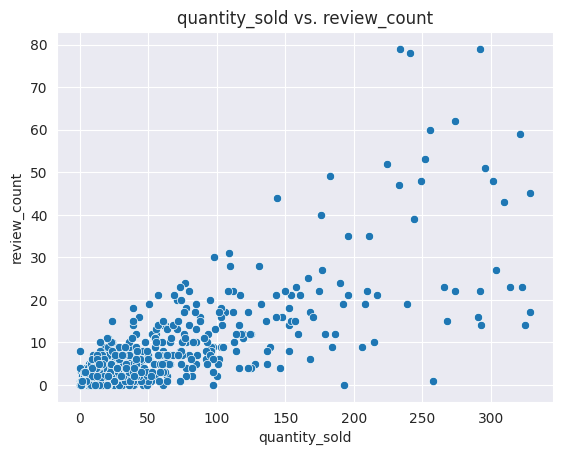

In [ ]:
def plot_scatter(df, f1, f2, hue=None):
    sns.scatterplot(x=df[f1], y=df[f2], data=df, hue=hue)
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title(f'{f1} vs. {f2}')
    plt.show()

plot_scatter(processed2_df[processed2_df['quantity_sold'] < processed2_df['quantity_sold'].mean() + processed2_df['quantity_sold'].std()], 'quantity_sold', 'review_count')

**As number of review increase, number of quantity sold increase**, that's what we expected

 ## Correlation between various columns
 Examine the correlation between various columns in the dataset using a heatmap visualization. By understanding the correlation between different variables, we can gain insights into how they are related to each other. This analysis helps identify any patterns or relationships that exist among the selected columns.

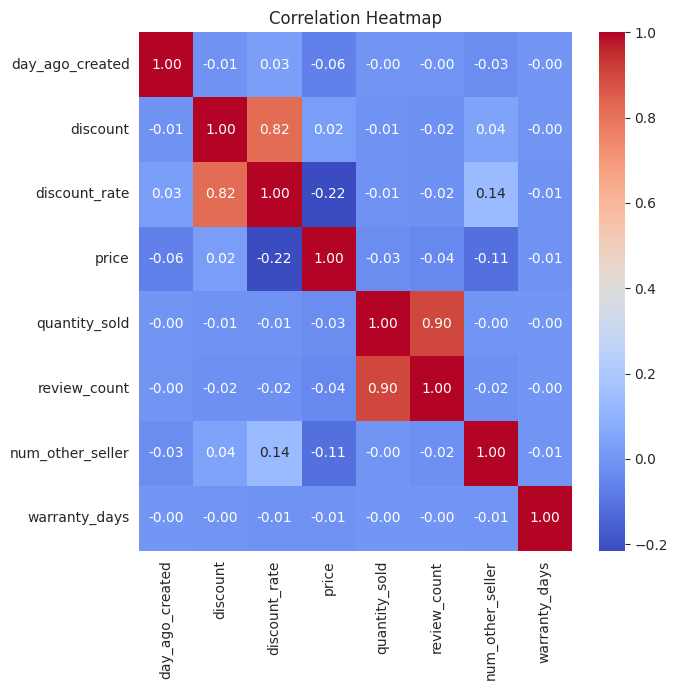

In [ ]:
# Plot the heatmap
plt.figure(figsize=(7, 7))
cols = ['day_ago_created', 'discount', 'discount_rate', 'price', 'quantity_sold', 'review_count', 'num_other_seller', 'warranty_days']
sns.heatmap(processed2_df[cols].corr(), cmap='coolwarm', annot=True, fmt = ".2f")
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

Can easily see that `quantity_sold` and `review_count` are very positive correlated

For the `price` and `discount_rate` are negative correlated, meaning that the more expensive product, the lower chance to get discount

# Clustering Store Kind
Clustering the `store_id` with the `price` can provide valuable insights into the relationship between different stores and their pricing patterns.

By performing this clustering analysis, we aim to identify groups or clusters of stores that exhibit similar pricing behavior. This can help us understand the pricing strategies adopted by different stores and potentially uncover distinct market segments.

## Cluster by Price

In the code below, we load the relevant data containing the `store_id` and `price` columns. We then perform clustering using the K-means algorithm, with the number of clusters set to 3 for demonstration purposes.

- 0 for Low-Price Stores
- 1 for Medium-Price Stores
- 2 for High-Price Store

In [ ]:
# get the average price per store_id
grouped_data = processed2_df.groupby('store_id')['price'].mean()

# prepare the data for clustering
data = grouped_data.values.reshape(-1, 1)
# use K-means to do clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

The code below visualize the distribution of stores across different price clusters. The goal is to understand how many stores fall into each price cluster category.

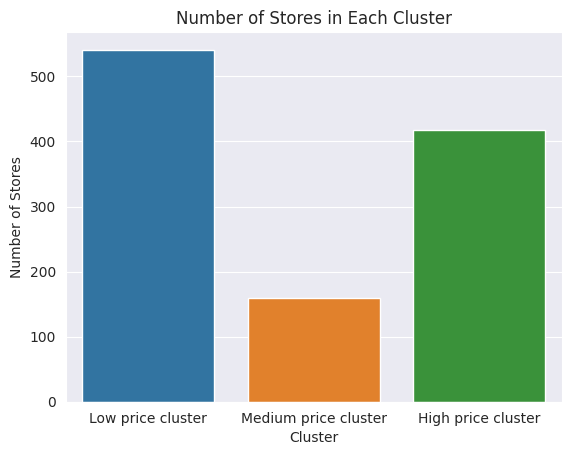

In [ ]:
grouped_data = grouped_data.to_frame()
grouped_data['store_kind'] = kmeans.labels_

# Count the number of stores in each cluster
store_count = grouped_data['store_kind'].value_counts()

# Plot the number of stores in each cluster
sns.barplot(x=store_count.index, y=store_count.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Stores')
plt.title('Number of Stores in Each Cluster')
plt.xticks([0, 1, 2], ['Low price cluster', 'Medium price cluster', 'High price cluster'])
plt.show()

With the given dataset, we found high proportion of store are selling low price products, just a few are selling medium price, the amount of high price product store are just a little bit less than low price product store.

Visualize the prices of stores within each price cluster to confirm that our clustering is working correctly

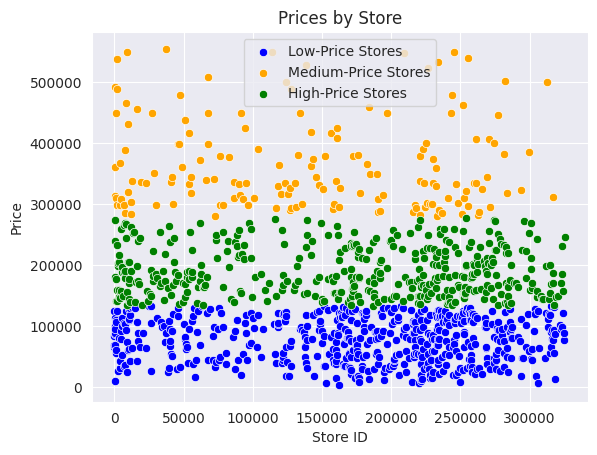

In [ ]:
grouped_data = grouped_data.reset_index()
# Plot store that in low price cluster
sns.scatterplot(data=grouped_data[grouped_data['store_kind'] == 0],
                x='store_id', y='price', color='blue', label='Low-Price Stores')
# Plot store that in medium price cluster
sns.scatterplot(data=grouped_data[grouped_data['store_kind'] == 1],
                x='store_id', y='price', color='orange', label='Medium-Price Stores')
# Plot store that in high price cluster
sns.scatterplot(data=grouped_data[grouped_data['store_kind'] == 2],
                x='store_id', y='price', color='green', label='High-Price Stores')
plt.xlabel('Store ID')
plt.ylabel('Price')
plt.title('Prices by Store')
plt.legend()
plt.show()

Let's see which kind of store get higher quantity sold

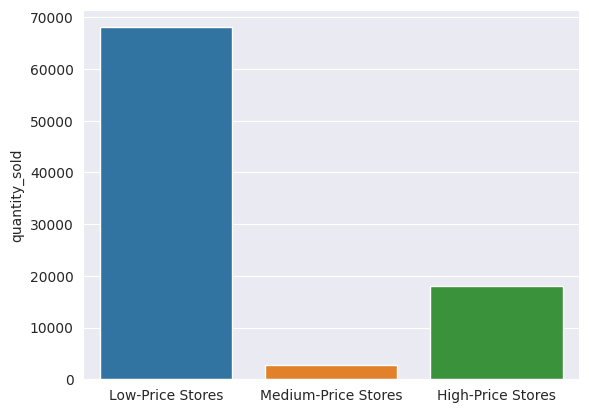

In [ ]:
grouped_data = processed2_df.groupby('store_id')['quantity_sold'].sum().to_frame().reset_index()
grouped_data['store_kind'] = kmeans.labels_
group_by_store_kind = grouped_data.groupby('store_kind')['quantity_sold'].sum().to_frame()

sns.barplot(x=['Low-Price Stores', 'Medium-Price Stores', 'High-Price Stores'], y=group_by_store_kind['quantity_sold'])
plt.ylabel("quantity_sold")
plt.show()

Of course low pride products will attract more customer than high price products, it makes sense when Low-Price Stores get higher quantity sold than the rest.

My coming question is
> Which kind of store is most competitive?

Meaning that whether Low-Price Stores have more number of other seller that sell same product, or it happen more regularly in High-Price Stores

            num_other_seller
store_kind                  
0                       3921
1                        113
2                       2762


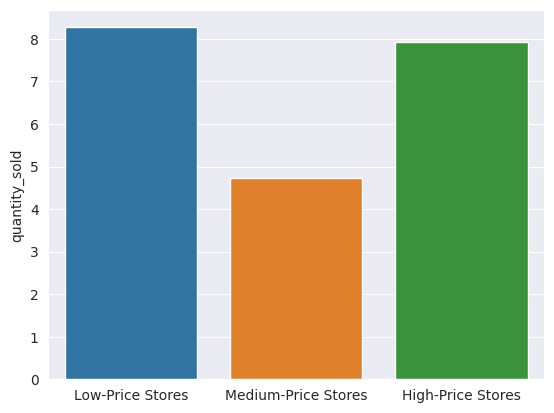

In [ ]:
grouped_data = processed2_df.groupby('store_id')['num_other_seller'].sum().to_frame().reset_index()
grouped_data['store_kind'] = kmeans.labels_
group_by_store_kind = grouped_data.groupby('store_kind')['num_other_seller'].sum().to_frame()
print(group_by_store_kind)
sns.barplot(x=['Low-Price Stores', 'Medium-Price Stores', 'High-Price Stores'], y=np.log(group_by_store_kind['num_other_seller']))
plt.ylabel("quantity_sold")
plt.show()

Answer for the question is **ALL**, people will think at just Low-Price Stores are competitive, but it happens even in High-Price Stores. In Medium-Price Stores, the competition is a bit reduced, but if we just split store into two kind, just Low-Prices Stores and High-Price Stores, I believe that these two kind of store share the same competition

## Cluster by Rating Average

Let's see if we devide the stores into ***high-rated stores*** and ***low-rated stores***

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


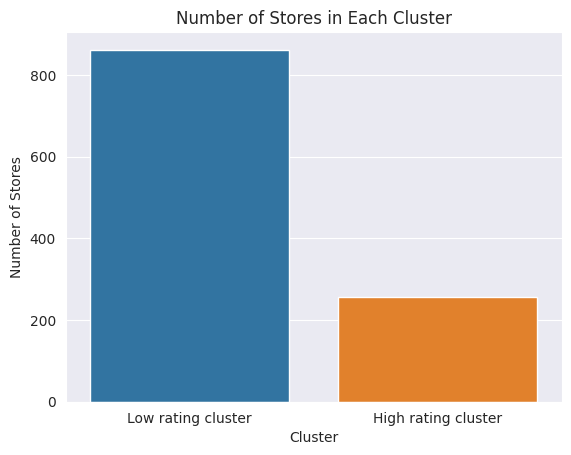

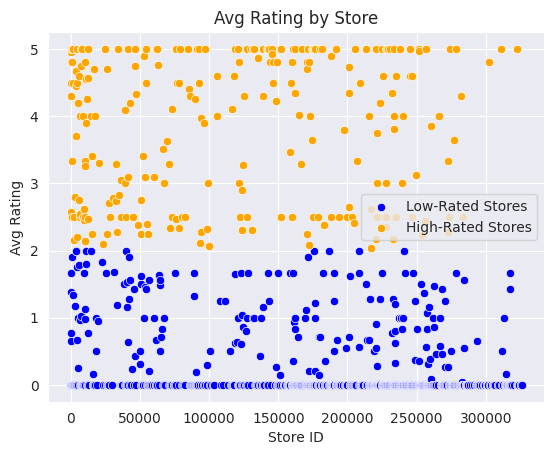

In [ ]:
# Train
grouped_data = processed2_df.groupby('store_id')['rating_average'].mean()
data = grouped_data.values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(data)


# Plot counting
grouped_data = grouped_data.to_frame()
grouped_data['store_kind'] = kmeans.labels_
store_count = grouped_data['store_kind'].value_counts()
sns.barplot(x=store_count.index, y=store_count.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Stores')
plt.title('Number of Stores in Each Cluster')
plt.xticks([0, 1], ['Low rating cluster', 'High rating cluster'])
plt.show()


# Plot Averaged Ratings by low-rated and high-rated stores
grouped_data = grouped_data.reset_index()
sns.scatterplot(data=grouped_data[grouped_data['store_kind'] == 0],
                x='store_id', y='rating_average', color='blue', label='Low-Rated Stores')
sns.scatterplot(data=grouped_data[grouped_data['store_kind'] == 1],
                x='store_id', y='rating_average', color='orange', label='High-Rated Stores')
plt.xlabel('Store ID')
plt.ylabel('Avg Rating')
plt.title('Avg Rating by Store')
plt.legend()
plt.show()

I wonder whether High-Rated Stores will sell high price products, or low price products, or both? How is it different from Low-Rated Stores.

Let's do some visualization to check

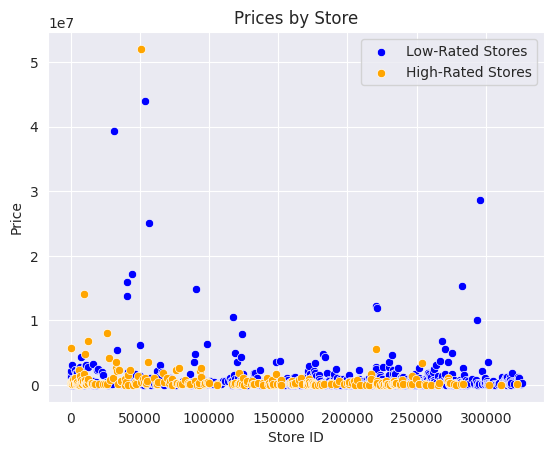

In [ ]:
grouped_data = processed2_df.groupby('store_id')['price'].sum().to_frame().reset_index()
grouped_data['store_kind'] = kmeans.labels_
group_by_store_kind = grouped_data.groupby('store_kind')['price'].sum().to_frame()

# Plot store that in low price cluster
sns.scatterplot(data=grouped_data[grouped_data['store_kind'] == 0],
                x='store_id', y='price', color='blue', label='Low-Rated Stores')
# Plot store that in medium price cluster
sns.scatterplot(data=grouped_data[grouped_data['store_kind'] == 1],
                x='store_id', y='price', color='orange', label='High-Rated Stores')
plt.xlabel('Store ID')
plt.ylabel('Price')
plt.title('Prices by Store')
plt.legend()
plt.show()

From the chart we can conclude High-Rated Stores sell all kind of products, from low price to high price, and the same for Low-Rated Stores

In [ ]:
# Conclusion

# Conclusion

After conducting exploratory data analysis (EDA) on the given dataset, we can draw several conclusions.

1. First, the dataset is not large (less than 10K products, very small if compared to the whole dataset which has more than 500K products), this could impact the statistical power and generalizability of the results. Therefore, it's important to keep in mind that the insights obtained from the analysis may not fully represent the entire population or exhibit robustness across different datasets.

2. During the EDA process, we explored various columns and their relationships. Some notable findings include:
    - Price Distribution: The distribution of product prices showed a wide range, indicating the presence of both low-priced and high-priced products. This suggests that the dataset covers a diverse range of price points.
    - Seller and Quantity Sold: We examined the relationship between the number of sellers and the quantity of products sold. It was observed that products with a higher number of sellers tended to have higher sales quantities. This could suggest that increased competition among sellers leads to higher product demand.
    - Discount Rate and Price: Analyzing the relationship between discount rates and product prices revealed that higher discount rates were associated with lower prices. This suggests that discounts play a role in influencing the pricing strategy of products.
    - Ratings and Reviews: Exploring the average ratings and review counts provided insights into customer satisfaction and engagement. Higher-rated products generally had a larger number of reviews, indicating that popular products tend to attract more customer feedback.

3. Overall, while the dataset size may limit, the EDA process provided valuable insights into the relationships and patterns present in the data. It is important to interpret the results within the context of the dataset's limitations and consider further analysis with larger datasets to enhance the validity and reliability of the conclusions.